In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/emmarex/plantdisease/data")

Skipping, found downloaded files in "./plantdisease" (use force=True to force download)


In [3]:
import os
root = "/content/plantdisease/PlantVillage"
classes = sorted(os.listdir(root))
print("Num classes:", len(classes))
for c in classes:
  path = os.path.join(root, c)
  if os.path.isdir(path):
    print(c, "->", len(os.listdir(path)))

Num classes: 15
Pepper__bell___Bacterial_spot -> 997
Pepper__bell___healthy -> 1478
Potato___Early_blight -> 1000
Potato___Late_blight -> 1000
Potato___healthy -> 152
Tomato_Bacterial_spot -> 2127
Tomato_Early_blight -> 1000
Tomato_Late_blight -> 1909
Tomato_Leaf_Mold -> 952
Tomato_Septoria_leaf_spot -> 1771
Tomato_Spider_mites_Two_spotted_spider_mite -> 1676
Tomato__Target_Spot -> 1404
Tomato__Tomato_YellowLeaf__Curl_Virus -> 3209
Tomato__Tomato_mosaic_virus -> 373
Tomato_healthy -> 1591


In [4]:
!pip install tensorflow

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255 , validation_split=0.2)

train_gen = datagen.flow_from_directory(root, target_size=(224, 224),
                                        batch_size =32, class_mode='categorical',
                                        subset='training', shuffle=True)

val_gen = datagen.flow_from_directory(root, target_size=(224,224),
                                      batch_size=32, class_mode='categorical',
                                      subset='validation', shuffle=True)




Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [13]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam



In [14]:
base_model = VGG19(
    weights='imagenet',  #use pre trained imagenet weights
    include_top=False,   #remove the classification head
    input_shape=(224, 224, 3)
)

In [15]:
for layer in base_model.layers:
  layer.trainable = False

In [16]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(15, activation='softmax')(x)

In [17]:

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 164s 287ms/step - accuracy: 0.5045 - loss: 1.6155 - val_accuracy: 0.8103 - val_loss: 0.6634
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 254ms/step - accuracy: 0.7719 - loss: 0.7405 - val_accuracy: 0.8501 - val_loss: 0.4772
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 253ms/step - accuracy: 0.8228 - loss: 0.5603 - val_accuracy: 0.8814 - val_loss: 0.4056
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 253ms/step - accuracy: 0.8589 - loss: 0.4461 - val_accuracy: 0.8760 - val_loss: 0.3702
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 254ms/step - accuracy: 0.8779 - loss: 0.3883 - val_accuracy: 0.9000 - val_loss: 0.3201
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 254ms/step - accuracy: 0.8913 - loss: 0.3426 - val_accuracy: 0.9010 - val_loss: 0.2991
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 253ms/step - accuracy: 0.9068 - loss: 0.2968 - val_accuracy: 0.9124 - val_loss: 0.2807
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 131s 253ms/step - accuracy: 0.9130 - loss: 0.27

In [19]:
loss , acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc*100:.2f}%")

129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.9169 - loss: 0.2354
Validation Accuracy: 92.07%


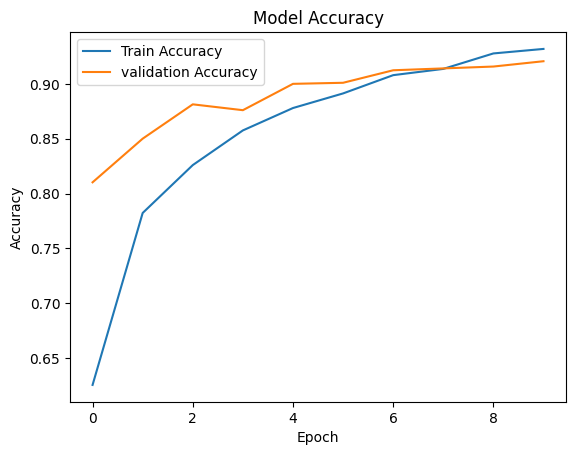

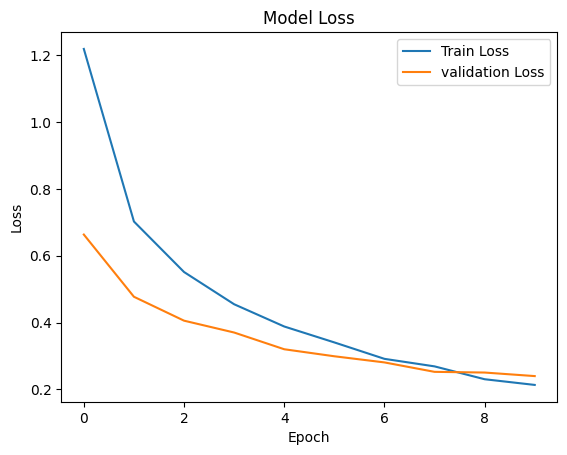

In [20]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
#unfreeze last few layers
for layer in base_model.layers[-4:]:
  layer.trainable = True

# recompile with smaller learning rate
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#fine tuning
history_fintune = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 153s 287ms/step - accuracy: 0.7984 - loss: 0.6170 - val_accuracy: 0.8724 - val_loss: 0.4013
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 278ms/step - accuracy: 0.8424 - loss: 0.4869 - val_accuracy: 0.8923 - val_loss: 0.3481
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 279ms/step - accuracy: 0.8721 - loss: 0.3860 - val_accuracy: 0.9027 - val_loss: 0.2937
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 278ms/step - accuracy: 0.8907 - loss: 0.3310 - val_accuracy: 0.9117 - val_loss: 0.2670
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 278ms/step - accuracy: 0.9016 - loss: 0.2963 - val_accuracy: 0.9270 - val_loss: 0.2304


In [25]:
loss , acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc*100:.2f}%")

129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 203ms/step - accuracy: 0.9220 - loss: 0.2386
Validation Accuracy: 92.70%


In [26]:
model.save("vgg19_plant_disease_final.h5")